# Import Drivers+, Download Overlay

In [1]:
import logging
import sys
import pynq
import time
from pynq import PL, buffer

import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio

import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.util
import mkidgen3.plotting
from mkidgen3.plotting import plot_waveforms, plot_res_chan
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc, trigger
#from mkidgen3.drivers.ifboard import IFBoard
from mkidgen3.testutils import *
import xrfclk
import xrfdc
from pynq import Overlay

In [2]:
# Download Overlay, Optionally Configure Clocks
bitstream='high_count_rate_test.bit'
#bitstream='gen3_top.bit'
ol = g3.overlay_helpers.configure(bitstream, ignore_version=True, clocks=False, programming_key='4.096GSPS_MTS', download=True)

## Generate Phase Data

In [3]:
from mkidreadoutanalysis.mkidnoiseanalysis import plot_channel_fft, plot_psd, apply_lowpass_filter, compute_r
from mkidreadoutanalysis.resonator import *
from mkidreadoutanalysis.mkidreadout import MKIDReadout

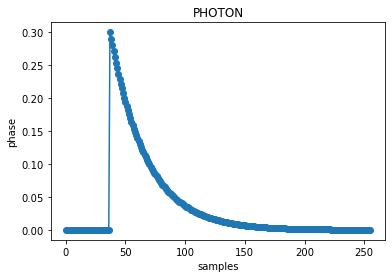

In [4]:
quasiparticle_timestream = QuasiparticleTimeStream(fs = 1e6, ts = 0.04)
quasiparticle_timestream.gen_quasiparticle_pulse(tf=30, magnitude=0.3);
quasiparticle_timestream.gen_photon_arrivals(cps=3)
quasiparticle_timestream.populate_photons()
pulse_start = 33550
pulse_end = pulse_start + 256 # 265 samples can fit in the dac table per resonator
plt.plot(quasiparticle_timestream.data[pulse_start:pulse_end],'o-')
plt.title('PHOTON');
plt.xlabel('samples');
plt.ylabel('phase');

### Resonator Loop

Create a resonator to map the IQ response too. The loop has been rotated using the `cable_delay` parameter so that the starting phase is ~ +pi.

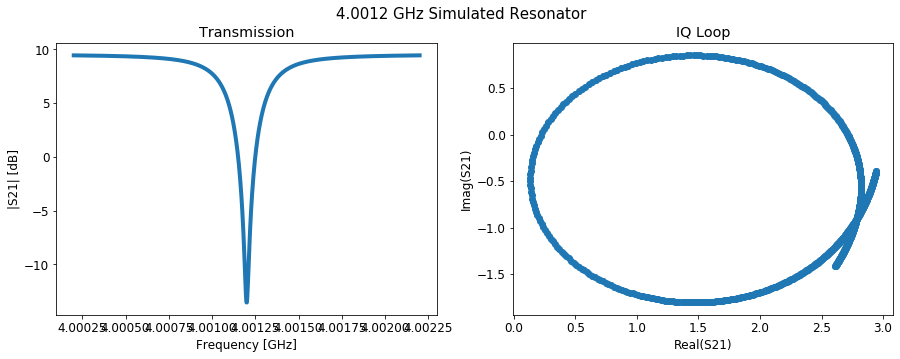

In [5]:
resonator = Resonator(f0=4.0012e9, qi=200000, qc=15000, xa=1e-9, a=0, tls_scale=1) #1e2
rf = RFElectronics(gain=(3.0, 0, 0), phase_delay=0-np.pi/10, cable_delay=50e-9)
freq = FrequencyGrid( fc=4.0012e9, points=1000, span=500e6)
sweep = ResonatorSweep(resonator, freq, rf)
sweep.plot_sweep()

### Create Resonator Response Object

In [6]:
lit_res_measurment = ReadoutPhotonResonator(resonator, quasiparticle_timestream, freq, rf)

### Define Noise

In [7]:
# toggle white noise and line noise
lit_res_measurment.noise_on = True

# adjust white noise scale
lit_res_measurment.rf.noise_scale = 30

# configure line noise
lit_res_measurment.rf.line_noise.freqs = ([60, 50e3, 100e3, 250e3, -300e3, 300e3, 500e3]) # Hz and relative to center of bin (MKID we are reading out)
lit_res_measurment.rf.line_noise.amplitudes = ([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.01])
lit_res_measurment.rf.line_noise.phases = ([0, 0.5, 0,1.3,0.5, 0.2, 2.4])

lit_res_measurment.rf.line_noise.freqs = ([500e3])
lit_res_measurment.rf.line_noise.amplitudes = ([0.00001])
lit_res_measurment.rf.line_noise.phases = ([0])

### Compute Loop Center

In [8]:
i_center = (np.percentile(sweep.s21.real, 95) + np.percentile(sweep.s21.real, 5)) / 2
q_center = (np.percentile(sweep.s21.imag, 95) + np.percentile(sweep.s21.imag, 5)) / 2

In [9]:
i_data = lit_res_measurment.iq_response.real-i_center
q_data = lit_res_measurment.iq_response.imag-q_center

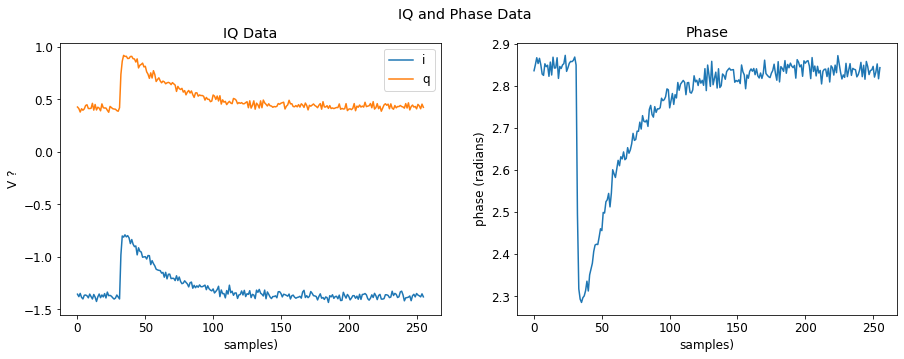

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('IQ and Phase Data')
ax1.plot(i_data[pulse_start:pulse_end])
ax1.plot(q_data[pulse_start:pulse_end])
ax1.set_ylabel('V ?')
ax1.set_title('IQ Data')
ax1.set_xlabel('samples)')
ax1.legend({'i','q'})
ax2.plot(np.arctan2(q_data,i_data)[pulse_start:pulse_end])
ax2.set_ylabel('phase (radians)')
ax2.set_xlabel('samples)')
ax2.set_title('Phase');

### Format for DAC Table

### Normalize data to proper fixed point representation

In [11]:
i_data = i_data[pulse_start:pulse_end]
q_data = q_data[pulse_start:pulse_end]
norm = np.abs(i_data+1j*q_data).max()
normalized_data = (i_data+1j*q_data)/norm
iq_vals = (normalized_data*2**14).round().clip(-2**14,2**14)

In [12]:
def interleave_dac(iq_vals, phase_offset=0, resonators=[0]):
    x = np.zeros((256,2048), dtype=np.complex64)
    for res in resonators:
        x[:,res] = np.roll(iq_vals,phase_offset)
    return x.reshape(2**19)

In [13]:
dac_table = interleave_dac(iq_vals, phase_offset=0, resonators = [0])

# Program Thresholds and Holdoffs

### Visualize Pulse to see how to set threshold and holdoff

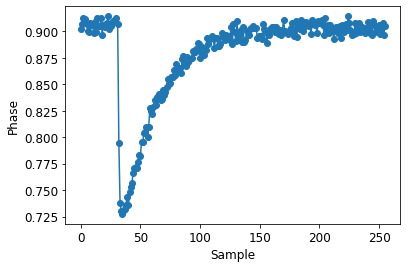

In [16]:
plt.plot(np.arctan2(q_data,i_data)/np.pi, "o-")
plt.xlabel('Sample');
plt.ylabel('Phase');

In [17]:
thresholds = -.8*np.ones(2048) # this won't trigger
holdoffs = 50*np.ones(2048,dtype=np.uint16)
thresholds[0]=0.8 # set the threshold right on channel 0
#holdoffs = holdoffs.astype(int).clip(0, 254)
thresholds, holdoffs

(array([ 0.8, -0.8, -0.8, ..., -0.8, -0.8, -0.8]),
 array([50, 50, 50, ..., 50, 50, 50], dtype=uint16))

In [18]:
ol.trigger_system.trigger_1.configure(thresholds, holdoffs)

In [19]:
ol.trigger_system.trigger_1._fetch()

(array([102, 154, 154, ..., 154, 154, 154], dtype=uint8),
 array([50, 50, 50, ..., 50, 50, 50], dtype=uint8))

### Spot check for a resonator

Raw Recorded Energy: 23838


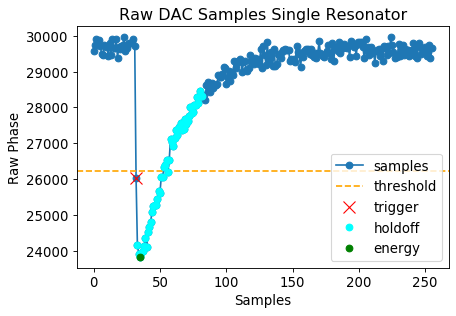

In [20]:
plt.figure(figsize=(6, 4), dpi=80)
res = 0
samples = np.arange(256)
pulse_data = np.arctan2(dac_table.imag[res::2048],dac_table.real[res::2048])/np.pi*2**15
threshold = thresholds[res]*2**15
trig = np.where(pulse_data < threshold)[0][0]
holdoff = holdoffs[res]
energy = trig+1+np.argmin(pulse_data[trig+1:trig+holdoff+1])

plt.plot(samples, pulse_data,"-o", label='samples')
plt.axhline(thresholds[res]*2**15,linestyle='--',color='orange', label='threshold')
plt.plot(samples[trig], pulse_data[trig],"x", color='r', label='trigger', markersize=10)
plt.plot(samples[trig+1:trig+holdoff+1], pulse_data[trig+1:trig+holdoff+1],"o", color='cyan', label='holdoff')
plt.plot(samples[energy], pulse_data[energy],"o", color='green', label='energy')

plt.title('Raw DAC Samples Single Resonator')
plt.xlabel('Samples')
plt.ylabel('Raw Phase')
plt.legend();

print(f"Raw Recorded Energy: {pulse_data[energy].round().astype('int')}")

# Configure Postage Filter

In [21]:
ol.trigger_system.postage_filter_0.configure(monitor_channels=[0,1,2,3,4,5,6,7])
ol.trigger_system.photon_maxi_0.capture();
ol.trigger_system.postage_maxi_0.capture();

## Start DAC Replay

In [22]:
ol.dac_table_axim_0.replay(dac_table, tlast=True, tlast_every=128, replay_len=None, start=True,
               fpgen=None, stop_if_needed=False)

## Check for Photons

In [23]:
photons = ol.trigger_system.photon_maxi_0.get_photons()

In [24]:
ol.trigger_system.photon_maxi_0.unpack_photons(photons)

array([(    35, 23838, 0), (   291, 23838, 0), (   547, 23838, 0),
       (   803, 23838, 0), (  1059, 23838, 0), (  1315, 23838, 0),
       (  1571, 23838, 0), (  1827, 23838, 0), (  2083, 23838, 0),
       (  2339, 23838, 0), (  2595, 23838, 0), (  2851, 23838, 0),
       (  3107, 23838, 0), (  3363, 23838, 0), (  3619, 23838, 0),
       (  3875, 23838, 0), (  4131, 23838, 0), (  4387, 23838, 0),
       (  4643, 23838, 0), (  4899, 23838, 0), (  5155, 23838, 0),
       (  5411, 23838, 0), (  5667, 23838, 0), (  5923, 23838, 0),
       (  6179, 23838, 0), (  6435, 23838, 0), (  6691, 23838, 0),
       (  6947, 23838, 0), (  7203, 23838, 0), (  7459, 23838, 0),
       (  7715, 23838, 0), (  7971, 23838, 0), (  8227, 23838, 0),
       (  8483, 23838, 0), (  8739, 23838, 0), (  8995, 23838, 0),
       (  9251, 23838, 0), (  9507, 23838, 0), (  9763, 23838, 0),
       ( 10019, 23838, 0), ( 10275, 23838, 0), ( 10531, 23838, 0),
       ( 10787, 23838, 0), ( 11043, 23838, 0), ( 11299, 23838,

# Postage Timestream

In [29]:
rids, iqs = ol.trigger_system.postage_maxi_0.get_postage()

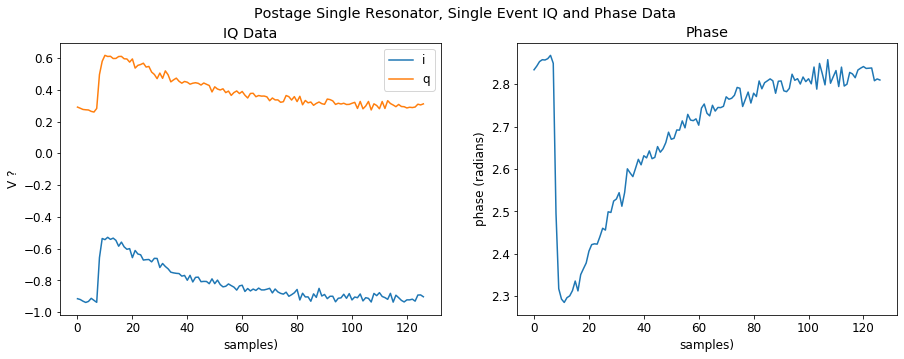

In [35]:
res = 0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Postage Single Resonator, Single Event IQ and Phase Data')
ax1.plot(iqs[rids==res][0,:].real)
ax1.plot(iqs[rids==res][0,:].imag)
ax1.set_ylabel('V ?')
ax1.set_title('IQ Data')
ax1.set_xlabel('samples)')
ax1.legend({'i','q'})
ax2.plot(np.angle(iqs[rids==0][0,:]))
ax2.set_ylabel('phase (radians)')
ax2.set_xlabel('samples)')
ax2.set_title('Phase');

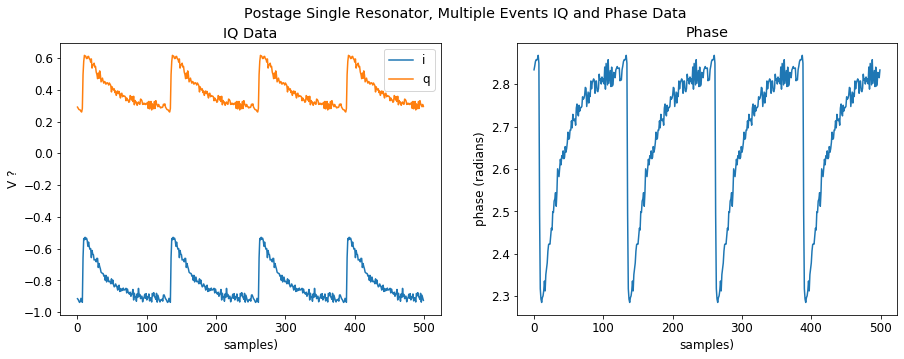

In [36]:
res = 0
data = iqs[rids==res].ravel()[0:500]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Postage Single Resonator, Multiple Events IQ and Phase Data')
ax1.plot(data.real)
ax1.plot(data.imag)
ax1.set_ylabel('V ?')
ax1.set_title('IQ Data')
ax1.set_xlabel('samples)')
ax1.legend({'i','q'})
ax2.plot(np.angle(data))
ax2.set_ylabel('phase (radians)')
ax2.set_xlabel('samples)')
ax2.set_title('Phase');